In [101]:
#dataset without any degradation
#dataloader 
#model getter 
#trainer

In [103]:
a = np.inf
for i in range(100):
    if i<a:
        a=i

In [3]:


import numpy as np
from torch.utils.data import Dataset

In [98]:
class BaseDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        pass

    def __getitem__(self, item):
        pass

    def crop_sequence(self, **kwargs):
        pass

    @staticmethod
    def augment_sequence(**kwargs):
        pass


In [99]:


class BaseDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        pass

    def __getitem__(self, item):
        pass

    @staticmethod
    def augment_sequence(**kwargs):
        pass

    def validate_dimension(self, lq_tensor, gt_tensor):
        lq_size = lq_tensor.size()
        lr_h, lr_w = lq_size[-1], lq_size[-2]
        gt_size = gt_tensor.size()
        gt_h, gt_w = gt_size[-1], gt_size[-2]
        if gt_h != lr_h * self.scale or gt_w != lr_w * self.scale:
            lq_tensor = torch.nn.functional.interpolate(
                gt_tensor,
                size=(self.gtsize // self.scale, self.gtsize // self.scale),
                mode="bicubic",
                align_corners=True,
            )
            gt_tensor = torch.nn.functional.interpolate(
                gt_tensor,
                size=(
                    int(self.gtsize // self.scale) * self.scale,
                    int(self.gtsize // self.scale) * self.scale,
                ),
                mode="bicubic",
                align_corners=True,
            )
        return lq_tensor, gt_tensor

    def crop_tensors(self, lq_tensor, gt_tensor):
        S, C, H, W = lq_tensor.shape
        LQ_size = self.gtsize // self.scale
        rnd_h = np.random.randint(0, max(0, H - LQ_size))
        rnd_w = np.random.randint(0, max(0, W - LQ_size))
        lq_tensor = lq_tensor[:, :, rnd_h : rnd_h + LQ_size, rnd_w : rnd_w + LQ_size]
        rnd_h_GT, rnd_w_GT = int(rnd_h * self.scale), int(rnd_w * self.scale)
        gt_tensor = gt_tensor[
            :, :, rnd_h_GT : rnd_h_GT + self.gtsize, rnd_w_GT : rnd_w_GT + self.gtsize
        ]
        return lq_tensor, gt_tensor

    def moving_frame_maker(self, frm: torch.Tensor):
        gt_imgs, lq_imgs = [], []
        _, h, w = frm.size()
        # generate random moving parameters
        offsets = np.floor(np.random.uniform(-3.5, 4.5, size=(self.sequence_length, 2)))
        offsets = offsets.astype(np.int32)
        pos = np.cumsum(offsets, axis=0)
        min_pos = np.min(pos, axis=0)
        topleft_pos = pos - min_pos
        range_pos = np.max(pos, axis=0) - min_pos
        c_h, c_w = h - range_pos[0], w - range_pos[1]
        c_h = (c_h // self.scale) * self.scale
        c_w = (c_w // self.scale) * self.scale
        # generate frames
        for i in range(self.sequence_length):
            top, left = topleft_pos[i]
            gt_img: torch.Tensor = frm[:, top : top + c_h, left : left + c_w]
            if self.scale == 1:
                lq_img = torch.empty_like(gt_img).copy_(gt_img)
            else:
                lq_img = imresize(gt_img, 1 / self.scale, True)
            lq_imgs.append(lq_img.unsqueeze(0))
            gt_imgs.append(gt_img.unsqueeze(0))
        return lq_imgs, gt_imgs


In [12]:

import os
import os.path as osp

import cv2
import numpy as np
import torch

# from utils.base_utils import retrieve_files

In [5]:

def read_img(env, path, size=None):
    '''read image by cv2 or from lmdb
    return: Numpy float32, HWC, BGR, [0,1]'''
    if env is None:  # img
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    else:
        img = _read_img_lmdb(env, path, size)
    img = img.astype(np.float32) / 255.
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    # some images have 4 channels
    if img.shape[2] > 3:
        img = img[:, :, :3]
    return img

In [6]:

def get_images_from_path(path):
    '''get image path list from image folder'''
    assert os.path.isdir(path), '{:s} is not a valid directory'.format(path)
    images = []
    for dirpath, _, fnames in sorted(os.walk(path)):
        for fname in sorted(fnames):
            if is_image_file(fname):
                img_path = os.path.join(dirpath, fname)
                images.append(img_path)
    assert images, '{:s} has no valid image file'.format(path)
    return images



IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

In [7]:
import os
import math
import pickle
import random
import numpy as np
import torch
import cv2
from scipy import signal    

IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def _get_paths_from_images(path):
    '''get image path list from image folder'''
    assert os.path.isdir(path), '{:s} is not a valid directory'.format(path)
    images = []
    for dirpath, _, fnames in sorted(os.walk(path)):
        for fname in sorted(fnames):
            if is_image_file(fname):
                img_path = os.path.join(dirpath, fname)
                images.append(img_path)
    assert images, '{:s} has no valid image file'.format(path)
    return images


def _get_paths_from_lmdb(dataroot):
    '''get image path list from lmdb meta info'''
    meta_info = pickle.load(open(os.path.join(dataroot, 'meta_info.pkl'), 'rb'))
    paths = meta_info['keys']
    sizes = meta_info['resolution']
    if len(sizes) == 1:
        sizes = sizes * len(paths)
    return paths, sizes


def get_image_paths(data_type, dataroot):
    '''get image path list
    support lmdb or image files'''
    paths, sizes = None, None
    if dataroot is not None:
        if data_type == 'lmdb':
            paths, sizes = _get_paths_from_lmdb(dataroot)
        elif data_type == 'img':
            paths = sorted(_get_paths_from_images(dataroot))
            # sizes = len(paths)
        else:
            raise NotImplementedError('data_type [{:s}] is not recognized.'.format(data_type))
    return paths, sizes


###################### read images ######################
def _read_img_lmdb(env, key, size):
    '''read image from lmdb with key (w/ and w/o fixed size)
    size: (C, H, W) tuple'''
    with env.begin(write=False) as txn:
        buf = txn.get(key.encode('ascii'))
    img_flat = np.frombuffer(buf, dtype=np.uint8)
    C, H, W = size
    img = img_flat.reshape(H, W, C)
    return img


def read_img(path,env=None, size=None):
    '''read image by cv2 or from lmdb
    return: Numpy float32, HWC, BGR, [0,1]'''
    if env is None:  # img
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    else:
        img = _read_img_lmdb(env, path, size)
    img = img.astype(np.float32) / 255.
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    # some images have 4 channels
    if img.shape[2] > 3:
        img = img[:, :, :3]
    return img


####################
# image processing
# process on numpy image
####################


def augment(img_list, hflip=True, rot=True):
    # horizontal flip OR rotate
    hflip = hflip and random.random() < 0.5
    vflip = rot and random.random() < 0.5
    rot90 = rot and random.random() < 0.5

    def _augment(img):
        if hflip:
            img = img[:, ::-1, :]
        if vflip:
            img = img[::-1, :, :]
        if rot90:
            img = img.transpose(1, 0, 2)
        return img

    return [_augment(img) for img in img_list]


def augment_flow(img_list, flow_list, hflip=True, rot=True):
    # horizontal flip OR rotate
    hflip = hflip and random.random() < 0.5
    vflip = rot and random.random() < 0.5
    rot90 = rot and random.random() < 0.5

    def _augment(img):
        if hflip:
            img = img[:, ::-1, :]
        if vflip:
            img = img[::-1, :, :]
        if rot90:
            img = img.transpose(1, 0, 2)
        return img

    def _augment_flow(flow):
        if hflip:
            flow = flow[:, ::-1, :]
            flow[:, :, 0] *= -1
        if vflip:
            flow = flow[::-1, :, :]
            flow[:, :, 1] *= -1
        if rot90:
            flow = flow.transpose(1, 0, 2)
            flow = flow[:, :, [1, 0]]
        return flow

    rlt_img_list = [_augment(img) for img in img_list]
    rlt_flow_list = [_augment_flow(flow) for flow in flow_list]

    return rlt_img_list, rlt_flow_list


def channel_convert(in_c, tar_type, img_list):
    # conversion among BGR, gray and y
    if in_c == 3 and tar_type == 'gray':  # BGR to gray
        gray_list = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in img_list]
        return [np.expand_dims(img, axis=2) for img in gray_list]
    elif in_c == 3 and tar_type == 'y':  # BGR to y
        y_list = [bgr2ycbcr(img, only_y=True) for img in img_list]
        return [np.expand_dims(img, axis=2) for img in y_list]
    elif in_c == 1 and tar_type == 'RGB':  # gray/y to BGR
        return [cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) for img in img_list]
    else:
        return img_list


def rgb2ycbcr(img, only_y=True):
    '''same as matlab rgb2ycbcr
    only_y: only return Y channel
    Input:
        uint8, [0, 255]
        float, [0, 1]
    '''
    in_img_type = img.dtype
    img.astype(np.float32)
    if in_img_type != np.uint8:
        img *= 255.
    # convert
    if only_y:
        rlt = np.dot(img, [65.481, 128.553, 24.966]) / 255.0 + 16.0
    else:
        rlt = np.matmul(img, [[65.481, -37.797, 112.0], [128.553, -74.203, -93.786],
                              [24.966, 112.0, -18.214]]) / 255.0 + [16, 128, 128]
    if in_img_type == np.uint8:
        rlt = rlt.round()
    else:
        rlt /= 255.
    return rlt.astype(in_img_type)


def bgr2ycbcr(img, only_y=True):
    '''bgr version of rgb2ycbcr
    only_y: only return Y channel
    Input:
        uint8, [0, 255]
        float, [0, 1]
    '''
    in_img_type = img.dtype
    img.astype(np.float32)
    if in_img_type != np.uint8:
        img *= 255.
    # convert
    if only_y:
        rlt = np.dot(img, [24.966, 128.553, 65.481]) / 255.0 + 16.0
    else:
        rlt = np.matmul(img, [[24.966, 112.0, -18.214], [128.553, -74.203, -93.786],
                              [65.481, -37.797, 112.0]]) / 255.0 + [16, 128, 128]
    if in_img_type == np.uint8:
        rlt = rlt.round()
    else:
        rlt /= 255.
    return rlt.astype(in_img_type)


def ycbcr2rgb(img):
    '''same as matlab ycbcr2rgb
    Input:
        uint8, [0, 255]
        float, [0, 1]
    '''
    in_img_type = img.dtype
    img.astype(np.float32)
    if in_img_type != np.uint8:
        img *= 255.
    # convert
    rlt = np.matmul(img, [[0.00456621, 0.00456621, 0.00456621], [0, -0.00153632, 0.00791071],
                          [0.00625893, -0.00318811, 0]]) * 255.0 + [-222.921, 135.576, -276.836]
    if in_img_type == np.uint8:
        rlt = rlt.round()
    else:
        rlt /= 255.
    return rlt.astype(in_img_type)


def modcrop(img_in, scale):
    # img_in: Numpy, HWC or HW
    img = np.copy(img_in)
    if img.ndim == 2:
        H, W = img.shape
        H_r, W_r = H % scale, W % scale
        img = img[:H - H_r, :W - W_r]
    elif img.ndim == 3:
        H, W, C = img.shape
        H_r, W_r = H % scale, W % scale
        img = img[:H - H_r, :W - W_r, :]
    else:
        raise ValueError('Wrong img ndim: [{:d}].'.format(img.ndim))
    return img


####################
# Functions
####################


# matlab 'imresize' function, now only support 'bicubic'
def cubic(x):
    absx = torch.abs(x)
    absx2 = absx**2
    absx3 = absx**3
    return (1.5 * absx3 - 2.5 * absx2 + 1) * (
        (absx <= 1).type_as(absx)) + (-0.5 * absx3 + 2.5 * absx2 - 4 * absx + 2) * ((
            (absx > 1) * (absx <= 2)).type_as(absx))


def calculate_weights_indices(in_length, out_length, scale, kernel, kernel_width, antialiasing):
    if (scale < 1) and (antialiasing):
        # Use a modified kernel to simultaneously interpolate and antialias- larger kernel width
        kernel_width = kernel_width / scale

    # Output-space coordinates
    x = torch.linspace(1, out_length, out_length)

    # Input-space coordinates. Calculate the inverse mapping such that 0.5
    # in output space maps to 0.5 in input space, and 0.5+scale in output
    # space maps to 1.5 in input space.
    u = x / scale + 0.5 * (1 - 1 / scale)

    # What is the left-most pixel that can be involved in the computation?
    left = torch.floor(u - kernel_width / 2)

    # What is the maximum number of pixels that can be involved in the
    # computation?  Note: it's OK to use an extra pixel here; if the
    # corresponding weights are all zero, it will be eliminated at the end
    # of this function.
    P = math.ceil(kernel_width) + 2

    # The indices of the input pixels involved in computing the k-th output
    # pixel are in row k of the indices matrix.
    indices = left.view(out_length, 1).expand(out_length, P) + torch.linspace(0, P - 1, P).view(
        1, P).expand(out_length, P)

    # The weights used to compute the k-th output pixel are in row k of the
    # weights matrix.
    distance_to_center = u.view(out_length, 1).expand(out_length, P) - indices
    # apply cubic kernel
    if (scale < 1) and (antialiasing):
        weights = scale * cubic(distance_to_center * scale)
    else:
        weights = cubic(distance_to_center)
    # Normalize the weights matrix so that each row sums to 1.
    weights_sum = torch.sum(weights, 1).view(out_length, 1)
    weights = weights / weights_sum.expand(out_length, P)

    # If a column in weights is all zero, get rid of it. only consider the first and last column.
    weights_zero_tmp = torch.sum((weights == 0), 0)
    if not math.isclose(weights_zero_tmp[0], 0, rel_tol=1e-6):
        indices = indices.narrow(1, 1, P - 2)
        weights = weights.narrow(1, 1, P - 2)
    if not math.isclose(weights_zero_tmp[-1], 0, rel_tol=1e-6):
        indices = indices.narrow(1, 0, P - 2)
        weights = weights.narrow(1, 0, P - 2)
    weights = weights.contiguous()
    indices = indices.contiguous()
    sym_len_s = -indices.min() + 1
    sym_len_e = indices.max() - in_length
    indices = indices + sym_len_s - 1
    return weights, indices, int(sym_len_s), int(sym_len_e)


def imresize(img, scale, antialiasing=True):
    # Now the scale should be the same for H and W
    # input: img: CHW RGB [0,1]
    # output: CHW RGB [0,1] w/o round

    in_C, in_H, in_W = img.size()
    _, out_H, out_W = in_C, math.ceil(in_H * scale), math.ceil(in_W * scale)
    kernel_width = 4
    kernel = 'cubic'

    # Return the desired dimension order for performing the resize.  The
    # strategy is to perform the resize first along the dimension with the
    # smallest scale factor.
    # Now we do not support this.

    # get weights and indices
    weights_H, indices_H, sym_len_Hs, sym_len_He = calculate_weights_indices(
        in_H, out_H, scale, kernel, kernel_width, antialiasing)
    weights_W, indices_W, sym_len_Ws, sym_len_We = calculate_weights_indices(
        in_W, out_W, scale, kernel, kernel_width, antialiasing)
    # process H dimension
    # symmetric copying
    img_aug = torch.FloatTensor(in_C, in_H + sym_len_Hs + sym_len_He, in_W)
    img_aug.narrow(1, sym_len_Hs, in_H).copy_(img)

    sym_patch = img[:, :sym_len_Hs, :]
    inv_idx = torch.arange(sym_patch.size(1) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(1, inv_idx)
    img_aug.narrow(1, 0, sym_len_Hs).copy_(sym_patch_inv)

    sym_patch = img[:, -sym_len_He:, :]
    inv_idx = torch.arange(sym_patch.size(1) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(1, inv_idx)
    img_aug.narrow(1, sym_len_Hs + in_H, sym_len_He).copy_(sym_patch_inv)

    out_1 = torch.FloatTensor(in_C, out_H, in_W)
    kernel_width = weights_H.size(1)
    for i in range(out_H):
        idx = int(indices_H[i][0])
        out_1[0, i, :] = img_aug[0, idx:idx + kernel_width, :].transpose(0, 1).mv(weights_H[i])
        out_1[1, i, :] = img_aug[1, idx:idx + kernel_width, :].transpose(0, 1).mv(weights_H[i])
        out_1[2, i, :] = img_aug[2, idx:idx + kernel_width, :].transpose(0, 1).mv(weights_H[i])

    # process W dimension
    # symmetric copying
    out_1_aug = torch.FloatTensor(in_C, out_H, in_W + sym_len_Ws + sym_len_We)
    out_1_aug.narrow(2, sym_len_Ws, in_W).copy_(out_1)

    sym_patch = out_1[:, :, :sym_len_Ws]
    inv_idx = torch.arange(sym_patch.size(2) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(2, inv_idx)
    out_1_aug.narrow(2, 0, sym_len_Ws).copy_(sym_patch_inv)

    sym_patch = out_1[:, :, -sym_len_We:]
    inv_idx = torch.arange(sym_patch.size(2) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(2, inv_idx)
    out_1_aug.narrow(2, sym_len_Ws + in_W, sym_len_We).copy_(sym_patch_inv)

    out_2 = torch.FloatTensor(in_C, out_H, out_W)
    kernel_width = weights_W.size(1)
    for i in range(out_W):
        idx = int(indices_W[i][0])
        out_2[0, :, i] = out_1_aug[0, :, idx:idx + kernel_width].mv(weights_W[i])
        out_2[1, :, i] = out_1_aug[1, :, idx:idx + kernel_width].mv(weights_W[i])
        out_2[2, :, i] = out_1_aug[2, :, idx:idx + kernel_width].mv(weights_W[i])

    return out_2


def imresize_np(img, scale, antialiasing=True):
    # Now the scale should be the same for H and W
    # input: img: Numpy, HWC BGR [0,1]
    # output: HWC BGR [0,1] w/o round
    img = torch.from_numpy(img)

    in_H, in_W, in_C = img.size()
    _, out_H, out_W = in_C, math.ceil(in_H * scale), math.ceil(in_W * scale)
    kernel_width = 4
    kernel = 'cubic'

    # Return the desired dimension order for performing the resize.  The
    # strategy is to perform the resize first along the dimension with the
    # smallest scale factor.
    # Now we do not support this.

    # get weights and indices
    weights_H, indices_H, sym_len_Hs, sym_len_He = calculate_weights_indices(
        in_H, out_H, scale, kernel, kernel_width, antialiasing)
    weights_W, indices_W, sym_len_Ws, sym_len_We = calculate_weights_indices(
        in_W, out_W, scale, kernel, kernel_width, antialiasing)
    # process H dimension
    # symmetric copying
    img_aug = torch.FloatTensor(in_H + sym_len_Hs + sym_len_He, in_W, in_C)
    img_aug.narrow(0, sym_len_Hs, in_H).copy_(img)

    sym_patch = img[:sym_len_Hs, :, :]
    inv_idx = torch.arange(sym_patch.size(0) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(0, inv_idx)
    img_aug.narrow(0, 0, sym_len_Hs).copy_(sym_patch_inv)

    sym_patch = img[-sym_len_He:, :, :]
    inv_idx = torch.arange(sym_patch.size(0) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(0, inv_idx)
    img_aug.narrow(0, sym_len_Hs + in_H, sym_len_He).copy_(sym_patch_inv)

    out_1 = torch.FloatTensor(out_H, in_W, in_C)
    kernel_width = weights_H.size(1)
    for i in range(out_H):
        idx = int(indices_H[i][0])
        out_1[i, :, 0] = img_aug[idx:idx + kernel_width, :, 0].transpose(0, 1).mv(weights_H[i])
        out_1[i, :, 1] = img_aug[idx:idx + kernel_width, :, 1].transpose(0, 1).mv(weights_H[i])
        out_1[i, :, 2] = img_aug[idx:idx + kernel_width, :, 2].transpose(0, 1).mv(weights_H[i])

    # process W dimension
    # symmetric copying
    out_1_aug = torch.FloatTensor(out_H, in_W + sym_len_Ws + sym_len_We, in_C)
    out_1_aug.narrow(1, sym_len_Ws, in_W).copy_(out_1)

    sym_patch = out_1[:, :sym_len_Ws, :]
    inv_idx = torch.arange(sym_patch.size(1) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(1, inv_idx)
    out_1_aug.narrow(1, 0, sym_len_Ws).copy_(sym_patch_inv)

    sym_patch = out_1[:, -sym_len_We:, :]
    inv_idx = torch.arange(sym_patch.size(1) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(1, inv_idx)
    out_1_aug.narrow(1, sym_len_Ws + in_W, sym_len_We).copy_(sym_patch_inv)

    out_2 = torch.FloatTensor(out_H, out_W, in_C)
    kernel_width = weights_W.size(1)
    for i in range(out_W):
        idx = int(indices_W[i][0])
        out_2[:, i, 0] = out_1_aug[:, idx:idx + kernel_width, 0].mv(weights_W[i])
        out_2[:, i, 1] = out_1_aug[:, idx:idx + kernel_width, 1].mv(weights_W[i])
        out_2[:, i, 2] = out_1_aug[:, idx:idx + kernel_width, 2].mv(weights_W[i])

    return out_2.numpy()

def scipy_conv(img, kernel):
    img[:, :, 0] = signal.convolve2d(img[:, :, 0], kernel[0, :, :], 'same')
    img[:, :, 1] = signal.convolve2d(img[:, :, 1], kernel[0, :, :], 'same')
    img[:, :, 2] = signal.convolve2d(img[:, :, 2], kernel[0, :, :], 'same')
    return img


In [8]:
from pathlib import Path
def list_dir(path):
    return [str(Path(path)/i) for i in os.listdir(path)]

In [9]:
def read_img(path, size=None):
    '''read image by cv2 or from lmdb
    return: Numpy float32, HWC, BGR, [0,1]'''
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype(np.float32) / 255.
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    # some images have 4 channels
    if img.shape[2] > 3:
        img = img[:, :, :3]
    return img

In [39]:
gt_dirs = ["../datasets/test/HR"]
# _get_paths_from_images("../datasets/test/HR/0001/")

In [64]:
paths=[]
for gt_dir in gt_dirs:
    #[video1,video2 ,...]
    i = [sorted(get_images_from_path(frame_path)) for frame_path in sorted(list_dir(gt_dir))]
    paths.extend(i)

In [60]:
list_dir("../datasets/test/HR/0001/")

['../datasets/test/HR/0001/im1.png',
 '../datasets/test/HR/0001/im2.png',
 '../datasets/test/HR/0001/im3.png',
 '../datasets/test/HR/0001/im4.png',
 '../datasets/test/HR/0001/im5.png',
 '../datasets/test/HR/0001/im6.png',
 '../datasets/test/HR/0001/im7.png']

In [146]:
# frame_paths
??read_img

Signature: read_img(env, path, size=None)
Source:   
def read_img(env, path, size=None):
    '''read image by cv2 or from lmdb
    return: Numpy float32, HWC, BGR, [0,1]'''
    if env is None:  # img
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    else:
        img = _read_img_lmdb(env, path, size)
    img = img.astype(np.float32) / 255.
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    # some images have 4 channels
    if img.shape[2] > 3:
        img = img[:, :, :3]
    return img
File:      /media/vinod/5B4F031A529188B2/projects/video-enhancer/playground/<ipython-input-142-c9c07c29f878>
Type:      function


In [77]:
np.random.randint(0,10)

1

In [66]:
np.random.uniform(0,1)

0.17810339285214838

In [100]:
class LQGT(BaseDataset):
    def __init__(self,gt_path,lq_path=None,gtsize=128,scale=2,sequence_length=10,moving_first_frame=True,**kwargs):
        """ Folder dataset with paired data
            support both BI & BD degradation
        """
        super(LQGT, self).__init__()
        self.gt_path = gt_path
        self.lq_path = lq_path
        self.scale = scale
        self.gtsize = gtsize
        self.sequence_length =sequence_length
        self.moving_first_frame = moving_first_frame
        self.pairs =[]
        if self.lq_path and type(lq_path) == str:
            lq_dirs = [lq_path]
        if  type(gt_path) == str:
            gt_dirs = [gt_path]
        
        gt_files = []
        lq_files =[]
        # [ [ video1 , video2 ,..],[video23,video24,..] ]
        for gt_dir in sorted(gt_dirs):
            #[video1,video2 ,...]
            single_video_frame_paths = [sorted(get_images_from_path(frame_path)) for frame_path in sorted(list_dir(gt_dir))]
            gt_files.extend(single_video_frame_paths)
        if self.lq_path:
            for lq_dir in sorted(lq_dirs):
                #[video1,video2 ,...]
                single_video_frame_paths = [sorted(get_images_from_path(frame_path)) for frame_path in sorted(list_dir(lq_dir))]
                lq_files.extend(single_video_frame_paths)
        
        if self.lq_path:
            assert len(gt_files) == len(lq_files)
        if not self.lq_path or len(lq_files)==0:
            pairs = [([],i) for i in gt_files]
        else:
            pairs = [(lq,gt) for lq,gt in zip(lq_files,gt_files)]
        
        #final check
        validated_pairs =[]
        for lq,gt in pairs:
            if len(lq)>0 and len(lq)!=len(gt):
                validated_pairs.append(([],gt))
            else:
                validated_pairs.append((lq,gt))
                
        self.pairs = validated_pairs
    def __len__(self):
        return len(self.pairs)
    
#     def moving_frame_maker(self,frm):
#         gt_imgs,lq_imgs =[],[]
#         c,h,w = frm.size()
#         # generate random moving parameters
#         offsets = np.floor(
#             np.random.uniform(-3.5, 4.5, size=(self.sequence_length, 2)))
#         offsets = offsets.astype(np.int32)
#         pos = np.cumsum(offsets, axis=0)
#         min_pos = np.min(pos, axis=0)
#         topleft_pos = pos - min_pos
#         range_pos = np.max(pos, axis=0) - min_pos
#         c_h, c_w = h - range_pos[0], w - range_pos[1]
#         c_h = ( c_h//self.scale ) * self.scale
#         c_w = ( c_w//self.scale ) * self.scale
#         # generate frames
#         for i in range(self.sequence_length):
#             top, left = topleft_pos[i]
#             gt_img = frm[:, top: top + c_h, left: left + c_w]
#             if self.scale==1:
#                 lq_img = torch.empty_like(gt_img).copy_(gt_img)
#             else:
#                 lq_img = imresize(gt_img, 1 / self.scale, True)
#             gt_imgs.append(gt_img.unsqueeze(0))
#             lq_imgs.append(lg_img.unsqueeze(0))
#         return lq_imgs,gt_imgs
    
    def __getitem__(self,item):
        lq_sequences, gt_sequences = self.pairs[item]
        if len(lq_sequences)==0:
            lq_sequences = [ None for i in gt_sequences ]
        gt_imgs,lq_imgs =[],[]
        pairs =list(zip(lq_sequences,gt_sequences))
        if self.moving_first_frame and self.scale>1 and np.random.uniform(0,1)<0.2:
            # load data
            frm = read_img(gt_sequences[0])  # chw|rgb|uint8
            frm = channel_convert(frm.shape[2], "RGB", [frm])[0]
            frm = torch.from_numpy(
                np.ascontiguousarray(np.transpose(frm, (2, 0, 1)))
            ).float()
            lq_imgs,gt_imgs = self.moving_frame_maker(frm)
        else:                
            start=np.random.randint(0,len(pairs)-self.sequence_length);
            pairs = pairs[start:start+self.sequence_length]
            for lq_frame,gt_frame in pairs:
                lq_resize = False
                img_GT = read_img(gt_frame)
                img_GT = channel_convert(img_GT.shape[2], "RGB", [img_GT])[0]
                H, W, _ = img_GT.shape
                if H < self.gtsize or W < self.gtsize:
                    img_GT = cv2.resize(
                        np.copy(img_GT), (self.gtsize, self.gtsize), interpolation=cv2.INTER_LINEAR
                    )
                    lq_resize = True
                if self.scale ==1 and None in (self.lq_path,lq_frame):
                    pass
                
                elif None in (self.lq_path,lq_frame) and not lq_resize and self.scale>1:
                    img_LQ = imresize_np(img_GT, 1 / self.scale, True)
                    if img_LQ.ndim == 2:
                        img_LQ = np.expand_dims(img_LQ, axis=2)
                else:
                    img_LQ = read_img(lq_frame)
                    img_LQ = channel_convert(img_LQ.shape[2], "RGB", [img_LQ])[0]
                img_GT = torch.from_numpy(
                    np.ascontiguousarray(np.transpose(img_GT, (2, 0, 1)))
                ).float()
                if self.scale>1 or (self.lq_path and lq_frame):
                    img_LQ = torch.from_numpy(
                        np.ascontiguousarray(np.transpose(img_LQ, (2, 0, 1)))
                    ).float()
                    lq_imgs.append(img_LQ.unsqueeze(0))
                gt_imgs.append(img_GT.unsqueeze(0))
        gt_imgs = torch.cat(gt_imgs,dim=0)
        if self.scale>1 or self.lq_path :
            lq_imgs = torch.cat(lq_imgs,dim=0)
        else:
            lq_imgs = torch.empty_like(gt_imgs).copy_(gt_imgs)
        print(lq_imgs.shape,gt_imgs.shape)
        lq_imgs,gt_imgs =  self.crop_tensors(lq_imgs,gt_imgs)
        lq_imgs,gt_imgs = self.validate_dimension(lq_imgs,gt_imgs)
        
        return lq_imgs,gt_imgs

#     def validate_dimension(self,lq_tensor,gt_tensor):
#         lq_size = lq_tensor.size()
#         lr_h, lr_w = lq_size[-1], lq_size[-2]
#         gt_size = gt_tensor.size()
#         gt_h, gt_w = gt_size[-1], gt_size[-2]
#         if gt_h != lr_h * self.scale or gt_w != lr_w * self.scale:
#             lq_tensor = torch.nn.functional.interpolate(
#                 gt_tensor,
#                 size=(self.gtsize // self.scale, self.gtsize // self.scale),
#                 mode="bicubic",
#                 align_corners=True,
#             )
#             gt_tensor = torch.nn.functional.interpolate(
#                 gt_tensor,
#                 size=(
#                     int(self.gtsize // self.scale) * self.scale,
#                     int(self.gtsize // self.scale) * self.scale,
#                 ),
#                 mode="bicubic",
#                 align_corners=True,
#             )
#         return lq_tensor,gt_tensor
        
#     def crop_tensors(self,lq_tensor,gt_tensor):
#         S,C,H,W = lq_tensor.shape
#         LQ_size = self.gtsize // self.scale        
#         rnd_h = np.random.randint(0, max(0, H - LQ_size))
#         rnd_w = np.random.randint(0, max(0, W - LQ_size))
#         lq_tensor = lq_tensor[:,:,rnd_h : rnd_h + LQ_size, rnd_w : rnd_w + LQ_size]
#         rnd_h_GT, rnd_w_GT = int(rnd_h * self.scale), int(rnd_w * self.scale)
#         gt_tensor = gt_tensor[:,:,rnd_h_GT : rnd_h_GT + self.gtsize, rnd_w_GT : rnd_w_GT + self.gtsize]
#         return lq_tensor,gt_tensor
    
lq="../datasets/test/HR/"
ds=LQGT("../datasets/test/HR",scale=4,gtsize=256,sequence_length=40,moving_first_frame=False)
for i in ds[1]:
    print(i.shape)

torch.Size([40, 3, 135, 240]) torch.Size([40, 3, 540, 960])
torch.Size([40, 3, 64, 64])
torch.Size([40, 3, 256, 256])


In [299]:
random.uniform(0, 1) < 0.

False

In [304]:
a=torch.randn(3,32,32)

In [398]:
torch.min(i)

tensor(0.0557)

In [405]:
i,j = ds[0]

torch.Size([40, 3, 135, 240]) torch.Size([40, 3, 540, 960])


In [387]:
# plt.imshow(i[0].)

In [337]:
i.shape,j.shape

(torch.Size([40, 3, 128, 128]), torch.Size([40, 3, 256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([40, 3, 135, 240]) torch.Size([40, 3, 540, 960])


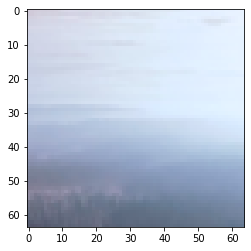

In [89]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.animation import PillowWriter,FFMpegWriter

i,j = ds[0]
fig, ax = plt.subplots()

images = []

for image in i:
    # images.append(np.transpose(image.numpy(), (1, 2, 0)))
    images.append([plt.imshow(np.transpose(image.squeeze().numpy(), (1, 2, 0)))])
anim = ArtistAnimation(fig, images, interval=100, repeat=True)
writer = FFMpegWriter(fps=5)
anim.save('./test_animation.mp4', writer=writer)
anim.save('./movie.gif', writer='pillow')
plt.show()

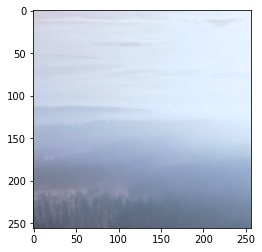

In [90]:

fig, ax = plt.subplots()

images = []

for image in j:
    # images.append(np.transpose(image.numpy(), (1, 2, 0)))
    images.append([plt.imshow(np.transpose(image.squeeze().numpy(), (1, 2, 0)))])
anim = ArtistAnimation(fig, images, interval=100, repeat=True)
writer = FFMpegWriter(fps=5)
anim.save('./test_animation0.mp4', writer=writer)
anim.save('./movie.gif', writer='pillow')
plt.show()

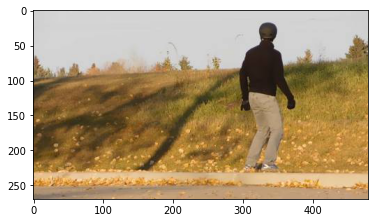

In [416]:
from PIL import Image
plt.imshow(np.array(Image.open("../datasets/test/LRx2-compressed/308349650.hd/0000000010.jpg")))

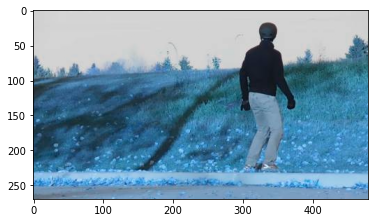

In [418]:
plt.imshow(read_img("../datasets/test/LRx2-compressed/308349650.hd/0000000010.jpg"))

torch.Size([40, 3, 270, 480]) torch.Size([40, 3, 540, 960])


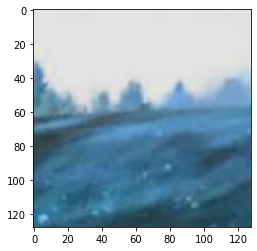

In [354]:
i,j=ds[3]
plt.imshow(torch.permute(i[9],(1,2,0)))

In [ ]:
i,j=ds[1]
plt.imshow(torch.permute(i[9],(1,2,0)))

######


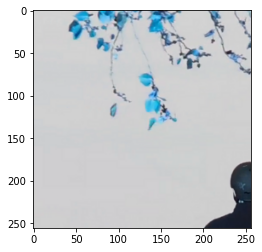

In [358]:
plt.imshow(torch.permute(j[30],(1,2,0)))

In [123]:
# ds.pairs

In [91]:
# ds[1]